In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import motive
import oe

In [5]:
date = "20250718" # change this according to ur session
animal = "eb02"

oe_sr = 30000
m_sr = 120

pyr = [7,26,45,53,56,64,68,79,83,89,90,115,125,137,167,178,183,189,228,230,232,233,234,256,403,414,426,427,428,429,430,434,441,444,445,446,455,457,458,460,470,471,472,473,474,475,476,477,494,495,512,513,516,519,545]
inter = [70,78,105,110,138,153,154,204,220,227,492,493]

csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

dat_path = rf'X:\eva\data\raw\oe\{animal}\{animal}_{date}\continuous.dat'
dat_path = pf.w2l(dat_path)

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

pitch_path = Path(res_path) / "pitch"
pitch_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

csv_path, dat_path, ks_path, res_path, pitch_path

('/storage3/eva/data/processed/eb02/eb02_20250718/motive/out_csv',
 '/storage3/eva/data/raw/oe/eb02/eb02_20250718/continuous.dat',
 '/storage3/eva/data/processed/eb02/eb02_20250718/kilosort',
 '/storage3/eva/code/neuropixels/results/eb02/eb02_20250718',
 PosixPath('/storage3/eva/code/neuropixels/results/eb02/eb02_20250718/pitch'))

In [7]:
res_path_path = Path(res_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

In [8]:
of_keys = list(periods.keys())[1::2] 

In [9]:
pitch_data = {}

for of in of_keys:
    with open(f"{pitch_path}/pf_data_dict1d_{of}_{date}.pkl", "rb") as f:
        pf_data_dict1d = pickle.load(f)
        pitch_data[of] = pf_data_dict1d

In [77]:
def flip_row_indices(a, b, n_shuffles=1000):
    a = np.asarray(a)
    b = np.asarray(b)
    assert a.shape == b.shape, "a and b must be same shape"

    shuffles = []
    for _ in range(n_shuffles):
        mask = np.random.rand(len(a)) < 0.5  # random True/False per column
        row0 = np.where(mask, b, a)
        row1 = np.where(mask, a, b)
        shuffles.append((row0, row1))
    return np.array(shuffles)

In [78]:
pitch_data['of1']['rm'][154].shape, pitch_data['of2']['rm'][154].shape

((32,), (32,))

In [79]:
def zscore_nan(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    return (arr - mean) / std

In [ ]:
unit = 89 #154
a = zscore_nan(pitch_data['of1']['rm'][unit])
b = zscore_nan(pitch_data['of2']['rm'][unit])

shuffles = flip_row_indices(a, b)
shuffles.shape

(1000, 2, 32)

In [94]:
def corr_with_nans(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    return np.corrcoef(a[mask], b[mask])[0, 1]

In [95]:
corrs = []

for sh in range(shuffles.shape[0]):
    corrs.append(corr_with_nans(shuffles[sh,0,:], shuffles[sh,1,:]))

In [96]:
len(corrs)

1000

In [97]:
true_corr = corr_with_nans(a, b)

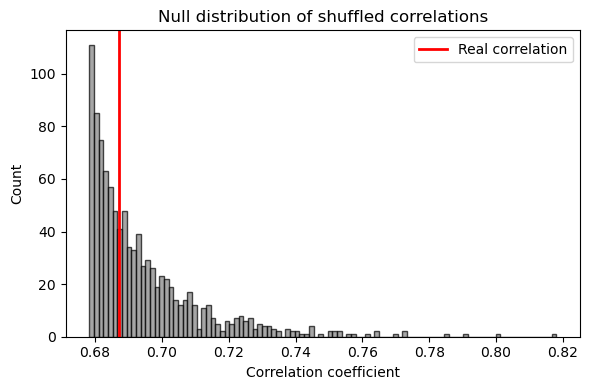

In [98]:
plt.figure(figsize=(6, 4))
plt.hist(corrs, bins=100, alpha=0.7, color='gray', edgecolor='black')
plt.axvline(true_corr, color='red', linewidth=2, label='Real correlation')
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
plt.title('Null distribution of shuffled correlations')
plt.legend()
plt.tight_layout()
plt.show()